In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from scipy.interpolate import griddata, RBFInterpolator, InterpolatedUnivariateSpline

In [2]:
import inferagni as ia

In [3]:
datadir = "../src/inferagni/data/"
data, input_vars, output_vars = ia.grid.load_from_dir(datadir)

Loading data from CSV files...
Data directory: ../src/inferagni/data/
Grid size: 264600
Input vars:  ['index', 'worker', 'frac_atm', 'frac_core', 'mass_tot', 'logCO', 'logZ', 'instellation', 'Teff']
Output vars: ['index', 'succ', 'flux_loss', 'r_bound', 'p_surf', 't_surf', 'r_surf', 'μ_surf', 'g_surf', 't_phot', 'r_phot', 'μ_phot', 'g_phot', 'vmr_H2', 'vmr_H2O', 'vmr_CO2', 'vmr_CO', 'vmr_O2', 'vmr_OH', 'vmr_NH3', 'vmr_NO2', 'vmr_N2', 'vmr_SO2', 'vmr_H2S', 'vmr_H2SO4', 'Kzz_max', 'conv_ptop', 'conv_pbot']
Loaded data


Plot instellation, frac_atm
Filter by logZ = 0.5
Filter by logCO = -1
Filter by frac_core = 0.325
Filter by Teff = 4450
Number of points: 500
vmin:1.0    vmax:1000.0


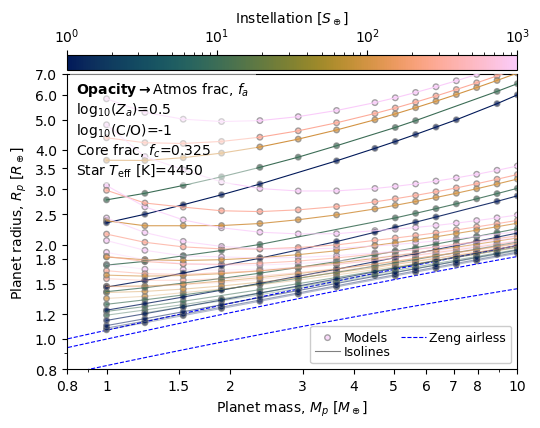

In [4]:
opts = {
    "key1"    : "instellation",
    "key2"    : "frac_atm",
    "controls": {"logZ":0.5, "logCO":-1,  "frac_core":0.325, "Teff":4450},
    "show_scatter" : True,
    "show_isolines" : True,
}

fig = ia.plot.plot_mr(data, **opts)
plt.show(fig)